In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import decimal
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from statsmodels.tsa.stattools import adfuller

In [2]:
##### Reading Final Baseband Data #####
#data = pd.read_csv('R3_data_final_bb.csv')
data = pd.read_csv('R3_bb_pub.csv')
print(data.columns.tolist())
sc = data["Scattering(s)"].to_numpy()
downsamp = data['Downsample'].to_numpy()

['Unnamed: 0', 'Event_id', 'DM_struc', 'Downsample', 'Scattering(s)', 'Widths(s)', 'Width_err(s)', 'Sc_err(s)', 'dm_offset', 'dm_offset_err', 'Peak_freq', 'Bandwidth', 'Center_Freq']


In [3]:
#### Reading Polarization Data #####
data_p = pd.read_csv('FRB20180916B_polarization_results.csv')

In [4]:
#### Copying values from polarization data-frame to main data-frame ####
data['rm_qu'] = data_p['rm_qu'].values
data['rm_fdf'] = data_p['rm_fdf'].values
data['MJD'] = data_p['mjd'].values
data['fracpol_lin'] = data_p['fracpol_lin'].values
data['RM_iono'] = data_p['rm_iono'].values

In [5]:
###### Adding Scattering error values from simulations ######
data['Scattering_err_spread'] = [2.7341, 40.7783, 0.5826, 0.9888, 7.1689, 4.9812, 0.8125, 1.9506, 6.1965, 6.6238, 4.4976, 1.5604, 15.268, 1.6443, 12.7575, 0.8796, 100.00, 7.5359, 5.2467, 0.5554, 1.5947, 3.7311, 4.5404, 6.8476, 0.8273, 7.3607, 1.7654, 3.0954, 10.9679, 0.4812, 4.3626, 6.9269, 1.4946, 6.212, 4.4848, 6.3477, 4.4375, 0.9527, 3.232, 1.3265, 39.387, 7.2653, 4.3496, 6.3097, 2.289]
data["Sc_err_sim(s)"] = (data["Scattering_err_spread"]/100)*data["Scattering(s)"]

In [6]:
###### Separating the errors from polarization data frame as they are in () #####
RM_FDF = []
RM_FDF_err = []

rm_fdf = data['rm_fdf'].to_numpy()
for i in range(len(rm_fdf)):
    r = float(rm_fdf[i].split('(')[0])
    RM_FDF.append(r)
    #print(r)
    e = float(rm_fdf[i].split('(')[1].split(')')[0])
    if e <= 4.0:
        RM_FDF_err.append(e)
        #print(e)
    else :
        RM_FDF_err.append(e/100)
        #print(e/100)
        
data['RM_FDF'] = RM_FDF
data['RM_FDF_err'] = RM_FDF_err


RM_QU = []
RM_QU_err = []

rm_qu = data['rm_qu'].to_numpy()
for i in range(len(rm_qu)):
    r = float(rm_qu[i].split('(')[0])
    RM_QU.append(r)
    #print(r)
    e = float(rm_qu[i].split('(')[1].split(')')[0])
    if e <= 6.0:
        RM_QU_err.append(e)
        #print(e)
    else :
        RM_QU_err.append(e/100)
        #print(e/100)
        
data['RM_QU'] = RM_QU
data['RM_QU_err'] = RM_QU_err

FRAC_POL = []
FRAC_POL_err = []

fpol = data['fracpol_lin'].to_numpy()
for i in range(len(fpol)):
    r = float(fpol[i].split('(')[0])
    FRAC_POL.append(r)
    #print(r)
    e = float(fpol[i].split('(')[1].split(')')[0])
    dec_point = decimal.Decimal(str(r))
    exp_point = dec_point.as_tuple().exponent
    e = e * 10**exp_point
    if e > 0.099:
        e = e/10
    FRAC_POL_err.append(float(e))
        #print(e)

        
data['F_POL'] = FRAC_POL
data['F_POL_err'] = FRAC_POL_err



In [7]:
###### Adding error #####
dm_err = [0.010, 0.023, 0.032, 0.15, 0.072, 0.46, 0.20, 
          0.0075, 0.083, 0.061, 0.12, 0.27, 0.20, 0.048,
         0.050, 0.25, 0.084, 0.57, 0.031, 0.0055, 0.34,
         0.13, 0.0098, 0.71, 0.0020, 0.31, 0.051, 0.45,
         0.020, 0.17, 0.37, 0.34, 0.21, 0.14, 0.0093,
         0.043, 0.012, 0.79, 1.9, 0.023, 0.014, 0.19, 0.25,
         0.16, 0.027]
data['DM_struc_err'] = dm_err

In [8]:
##### Dropping the already existing folder and replacing them with value and error separate ####
data = data.drop(['rm_qu','rm_fdf','fracpol_lin','Unnamed: 0'], axis=1)
rm = data['RM_FDF'].to_numpy().astype(float)
rm_i = data['RM_iono'].to_numpy().astype(float)
rm = rm + rm_i
rm_err = data['RM_FDF_err'].to_numpy().astype(float)
f_pol = data['F_POL'].to_numpy().astype(float)
f_pol_err = data['F_POL_err'].to_numpy().astype(float)

In [9]:
### Calculating Phase ####
ref_mjd = 58369.40
period = 16.34
data['phase'] = ((data['MJD']-ref_mjd)/period)%1

In [10]:
##### Calculating Final DM ######
data['DM_final'] = data['DM_struc']+data['dm_offset']
data['DM_err_final'] = data['DM_struc_err']+data['dm_offset_err']

In [11]:
###### Calculating Max of width #######
data['Width_max'] = [max(x) for x in data['Widths(s)']]
data['Width_max_err'] = [max(x) for x in data['Width_err(s)']]

In [12]:
#### Reading Intensity Fit data from Round 3 and Round 2 fitburst fits #####
data_i_sc = pd.read_csv('R3_intensity_round3.csv')
data_i_sc_no = pd.read_csv('R3_intensity_round2.csv')
w_test = data_i_sc['Widths(s)'].to_numpy()

In [13]:
##### Adding all sub-burst widths to make one width for baseband data ####
width = data['Widths(s)'].to_numpy()
width_err = data['Width_err(s)'].to_numpy()
w = np.zeros(len(width))
w_err = np.zeros(len(width))
w_ = []
w_err_ = []
down = data['Downsample'].to_numpy()
for i in range(len(w)):
    x = width[i][1:-1].split()
    y = width_err[i][1:-1].split()
    x = [float(x) for x in x]
    y = [float(y) for y in y]
    w_.append(x)
    w_err_.append(y)
#     w[i] = x[x>0]
#     w_err[i] = y[y>0]

w_sum = []
w_err_sum = []

print(w_)

for i in range(len(w_)):
    x = 0
    y = 0
    for j in range(len(w_[i])):
        if (0 < w_[i][j] < 0.1) and (w_[i][j] > 2.56e-6):
            x = x + w_[i][j]**2
            y = y + w_err_[i][j]**2
    x = np.sqrt(x)
    y = np.sqrt(y)
    w_sum.append(x)
    w_err_sum.append(y)
w_sum = np.array(w_sum)
w_err_sum = np.array(w_err_sum)

print(w_sum)
print(w_err_sum)

[[0.00019754, 0.00043446], [0.0001652, 0.00018599], [0.00104376, 0.00087314, 0.00149603, 0.00099575], [0.00221424], [0.0043958402, 0.000138754355, 0.000262255711, 6.84351834e-07, 0.0015680425, 0.000611724911], [0.00286337], [0.00453753, 0.0009242], [0.00247613], [0.001058], [0.00058562, 0.00137229], [0.0012949, 0.00010538], [0.00104536], [0.00271838, 0.00214261], [0.00137209], [0.00016915], [0.00401867], [0.00030574, 0.00265097], [0.00183448], [0.00137612], [7.7947327e-05, 0.00201422486, 0.00105753817], [0.00348217, 0.00511547], [0.00176262], [0.00041749, 0.00019325], [0.0021192], [0.0006721, 0.00054339, 0.00226777], [0.00166871], [0.00178257], [0.00255664], [0.00090752], [0.00142966], [0.00156359], [0.00137777], [0.00187204], [0.00178407], [0.00012615], [0.00086839, 0.00016106, 0.00010824], [0.00068925], [0.0017606, 0.00151392], [0.00342341], [0.00097625], [0.000378426412, 8.73476928e-05], [0.00180751, -0.20152836], [0.00154621], [0.00071105], [0.0002394, 0.00085782, 0.00033397]]
[0.0

In [14]:
#### Adding width for Round 3 intensity data ####
width_i3 = data_i_sc['Widths(s)'].to_numpy()
width_err_i3 = data_i_sc['Width_err(s)'].to_numpy()
w = np.zeros(len(width_i3))
w_err = np.zeros(len(width_err_i3))
w_ = []
w_err_ = []
for i in range(len(w)):
    x = width_i3[i][1:-1].split()
    y = width_err_i3[i][1:-1].split()
    x = [float(x) for x in x]
    y = [float(y) for y in y]
    w_.append(x)
    w_err_.append(y)
#     w[i] = x[x>0]
#     w_err[i] = y[y>0]
#print(w_[0][1], w_err_[0][1])

w_sum_i3 = []
w_err_sum_i3 = []

for i in range(len(w_)):
    x = 0
    y = 0
    for j in range(len(w_[i])):
        if 0 < w_[i][j] < 0.1:
            x = x + w_[i][j]**2
            y = y + w_err_[i][j]**2
    x = np.sqrt(x)
    y = np.sqrt(y)
    w_sum_i3.append(x)
    w_err_sum_i3.append(y)
w_sum_i3 = np.array(w_sum_i3)
w_err_sum_i3 = np.array(w_err_sum_i3)

In [15]:
#### Adding width for Round 2 intensity data ######
width_i2 = data_i_sc_no['Widths(s)'].to_numpy()
width_err_i2 = data_i_sc_no['Width_err(s)'].to_numpy()
w = np.zeros(len(width_i2))
w_err = np.zeros(len(width_err_i2))
w_ = []
w_err_ = []
for i in range(len(w)):
    x = width_i2[i][1:-1].split()
    y = width_err_i2[i][1:-1].split()
    x = [float(x) for x in x]
    y = [float(y) for y in y]
    w_.append(x)
    w_err_.append(y)
#     w[i] = x[x>0]
#     w_err[i] = y[y>0]
#print(w_[0][1], w_err_[0][1])

w_sum_i2 = []
w_err_sum_i2 = []

for i in range(len(w_)):
    x = 0
    y = 0
    for j in range(len(w_[i])):
        if 0 < w_[i][j] < 0.1:
            x = x + w_[i][j]**2
            y = y + w_err_[i][j]**2
    x = np.sqrt(x)
    y = np.sqrt(y)
    w_sum_i2.append(x)
    w_err_sum_i2.append(y)
w_sum_i2 = np.array(w_sum_i2)
w_err_sum_i2 = np.array(w_err_sum_i2)

In [16]:
##### Converting all Round 3 column's to numpy for easier plotting #####
d_i3 = data_i_sc['Downsample'].to_numpy().astype(int)
sc_i3 = data_i_sc['Scattering(s)'].to_numpy().astype(float)
sc_err_i3 = data_i_sc['Sc_err(s)'].to_numpy().astype(float)

dm_i3 = data_i_sc['DM_fitburst'].to_numpy().astype(float)
dm_err_i3 = data_i_sc['DM_err_fitburst'].to_numpy().astype(float)

cf_i3 = data_i_sc['Center_Freq'].to_numpy().astype(float)
bw_i3 = data_i_sc['Bandwidth'].to_numpy().astype(float)

TOA_i3 = data_i_sc['TOA'].to_numpy().astype(float)
phase_i3 = data_i_sc['phase'].to_numpy().astype(float)

# for i in range(len(phase_i3)):
#     if phase_i3[i] > 0.63380:
#         phase_i3[i] = 0.

In [17]:
##### Converting all Round 2 column's to numpy for easier plotting #####
d_i2 = data_i_sc_no['Downsample'].to_numpy().astype(int)
sc_i2 = data_i_sc_no['Scattering(s)'].to_numpy().astype(float)
sc_err_i2 = data_i_sc_no['Sc_err(s)'].to_numpy().astype(float)

dm_i2 = data_i_sc_no['DM_fitburst'].to_numpy().astype(float)
dm_err_i2 = data_i_sc_no['DM_err_fitburst'].to_numpy().astype(float)

cf_i2 = data_i_sc_no['Center_Freq'].to_numpy().astype(float)
bw_i2 = data_i_sc_no['Bandwidth'].to_numpy().astype(float)

TOA_i2 = data_i_sc_no['TOA'].to_numpy().astype(float)
phase_i2 = data_i_sc_no['phase'].to_numpy().astype(float)

# for i in range(len(phase_i3)):
#     if phase_i[i] > 0.63380:
#         phase_i3[i] = 0.

The Adfuller p value for scattering 1.7063454719872467e-10


<ipython-input-30-d4f5f796b1bc>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


The Adfuller p value for DM 1.6386918623201225e-08


<ipython-input-30-d4f5f796b1bc>:124: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
<ipython-input-30-d4f5f796b1bc>:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-30-d4f5f796b1bc>:172: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])

[   2    5   10   20   40   81  163  327  655 1310]


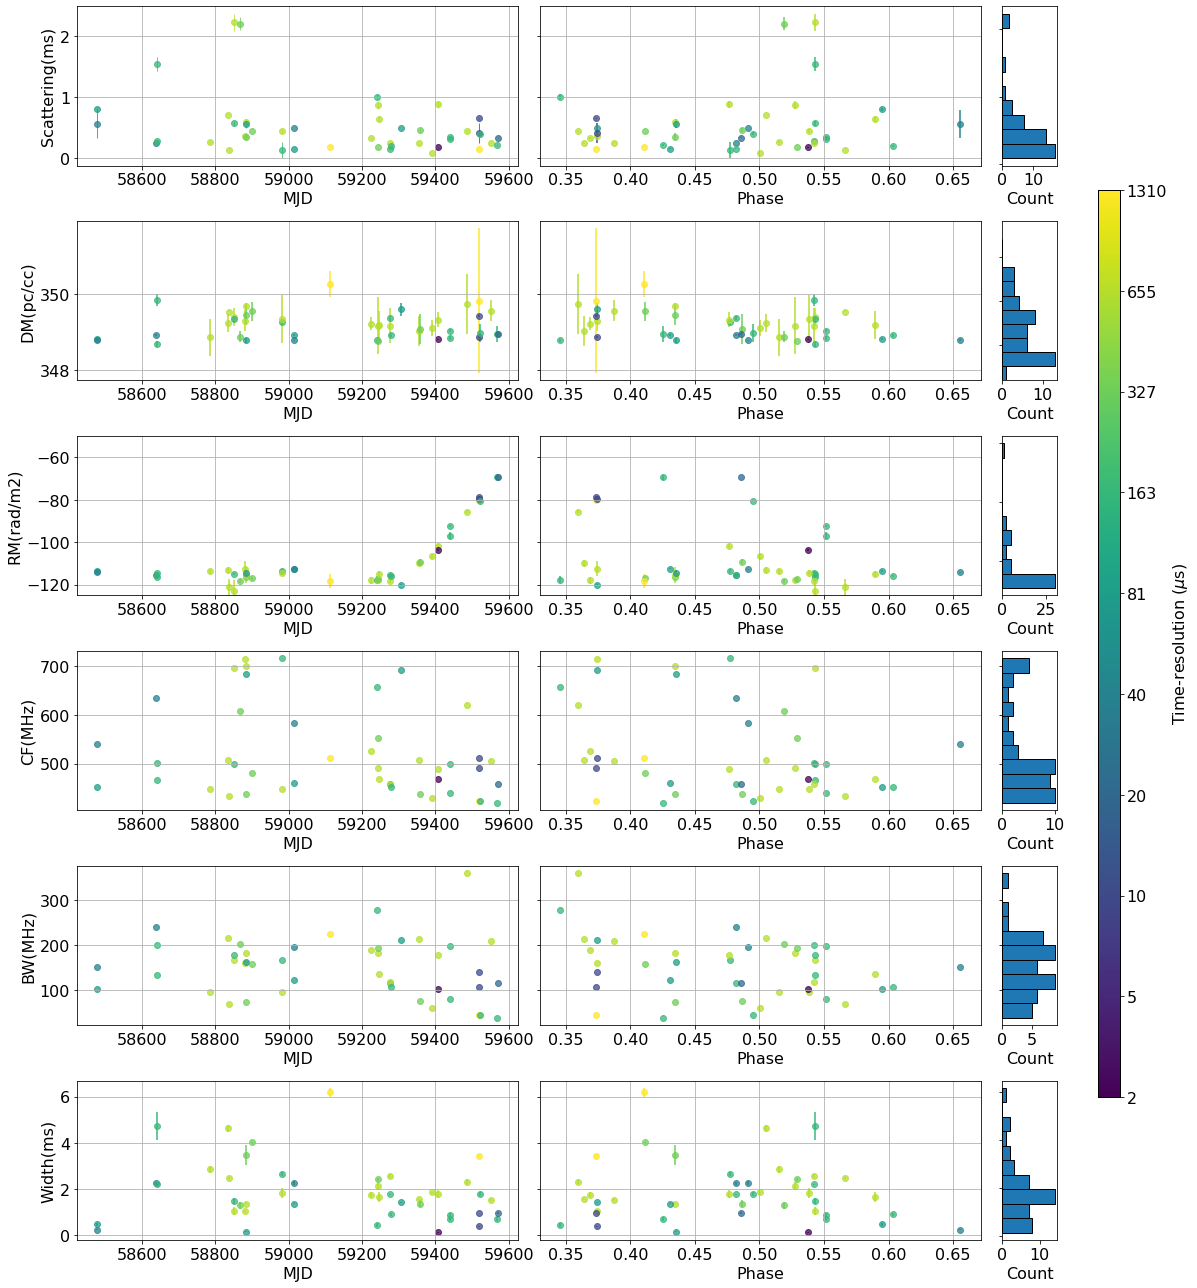

In [30]:
##### The main plotting script. All the commented ones are intensity data ######

fig, ax = plt.subplots(6, 3, figsize = (15,18), gridspec_kw={'width_ratios': [2, 2, 0.25]})

tick_sizes = 16
font_sizes = 16

##### Scattering ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
sc = data['Scattering(s)'].to_numpy().astype(float)

sc_test_result = adfuller(sc) ### Test to check whether time series is stationary. 
print("The Adfuller p value for scattering", sc_test_result[1]) #### If p-value < 0.05 then stationary

sc_err = data['Sc_err_sim(s)'].to_numpy().astype(float)

TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)

c_dsamps = np.zeros(len(d)).astype('str')

norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)

for x, y, e, color in zip(TOA, sc*1000, sc_err*1000, width_color): 
    ax[0 ,0].errorbar(x, y, yerr=e, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')

## Intensity Part ###
# ax[0 ,0].errorbar(TOA_i3, sc_i3*1000, yerr=sc_err_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')

# ax[0 ,0].errorbar(TOA_i2, sc_i2*1000, yerr=sc_err_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[0, 0].set_ylabel("Scattering(ms)", fontsize = font_sizes)
ax[0, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[0, 0].grid()


for x, y, e, color in zip(phase, sc*1000, sc_err*1000, width_color):
    ax[0, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[0 ,1].errorbar(phase_i3, sc_i3*1000, yerr=sc_err_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[0 ,1].errorbar(phase_i2, sc_i2*1000, yerr=sc_err_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[0, 1].set_ylabel("Scattering(ms)", fontsize = 14)
ax[0, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[0, 1].grid()

ax[0, 2].hist(sc*1000, orientation='horizontal', edgecolor='k')
ax[0, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')


ax[0, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[0, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[0, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()
#plt.savefig("Scattering_2.jpeg", dpi = 300, bbox_inches = 'tight')



#### DM ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
dm = data['DM_final'].to_numpy().astype(float)

dm_test_result = adfuller(dm) ### Test to check whether time series is stationary. 
print("The Adfuller p value for DM", dm_test_result[1]) #### If p-value < 0.05 then stationary

dm_err = data['DM_err_final'].to_numpy().astype(float)
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, dm, dm_err, width_color):
    ax[1,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

# ax[1 ,0].errorbar(TOA_i3, dm_i3, yerr=dm_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[1 ,0].errorbar(TOA_i2, dm_i2, yerr=dm_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[1, 0].set_ylabel("DM(pc/cc)", fontsize = font_sizes)
ax[1, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[1, 0].grid()


for x, y, e, color in zip(phase, dm, dm_err, width_color):
    ax[1, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[1 ,1].errorbar(phase_i3, dm_i3, yerr=dm_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[1 ,1].errorbar(phase_i2, dm_i2, yerr=dm_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[1, 1].set_ylabel("DM(pc/cc)", fontsize = 14)
ax[1, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[1, 1].grid()

ax[1, 2].hist(dm, orientation='horizontal', edgecolor='k', range=(348.6,350.2))
ax[1, 2].set_xlabel("Count", fontsize=font_sizes)
ax[1, 2].set_ylim(348.6,350.4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[1, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[1, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[1, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()


#### RM ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
rm = data['RM_QU'].to_numpy().astype(float)
rm_err = data['RM_QU_err'].to_numpy().astype(float)
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, rm, rm_err, width_color):
    ax[2,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

ax[2, 0].set_ylabel("RM(rad/m2)", fontsize = font_sizes)
ax[2, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[2, 0].set_ylim(-125, -50)
ax[2, 0].grid()


for x, y, e, color in zip(phase, rm, rm_err, width_color):
    ax[2, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


#ax[2, 1].set_ylabel("RM(rad/m2)", fontsize = 14)
ax[2, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[2, 1].set_ylim(-125, -50)
ax[2, 1].grid()

ax[2, 2].hist(rm, orientation='horizontal', edgecolor='k')
ax[2, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[2, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[2, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[2, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()

#### Center Frequency #####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
cf = data['Center_Freq'].to_numpy().astype(float)
cf_err = np.zeros(len(cf))
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, cf, cf_err, width_color):
    ax[3,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

# cf_err_i3 = np.zeros(len(cf_i3))
# ax[3 ,0].errorbar(TOA_i3, cf_i3, yerr=cf_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# cf_err_i2 = np.zeros(len(cf_i2))
# ax[3 ,0].errorbar(TOA_i2, cf_i2, yerr=cf_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[3, 0].set_ylabel("CF(MHz)", fontsize = font_sizes)
ax[3, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[3, 0].grid()


for x, y, e, color in zip(phase, cf, cf_err, width_color):
    ax[3, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[3 ,1].errorbar(phase_i3, cf_i3, yerr=cf_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[3 ,1].errorbar(phase_i2, cf_i2, yerr=cf_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[3, 1].set_ylabel("CF(MHz)", fontsize = 14)
ax[3, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[3, 1].grid()

ax[3, 2].hist(cf, orientation='horizontal', edgecolor='k')
ax[3, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[3, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[3, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[3, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()

##### Bandwidth #######

d = np.log2(data['Downsample'].to_numpy()).astype(int)
bw = data['Bandwidth'].to_numpy().astype(float)
bw_err = np.zeros(len(bw))
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, bw, bw_err, width_color):
    ax[4,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

# bw_err_i3 = np.zeros(len(bw_i3))
# ax[4 ,0].errorbar(TOA_i3, bw_i3, yerr=bw_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# bw_err_i2 = np.zeros(len(bw_i2))
# ax[4 ,0].errorbar(TOA_i2, bw_i2, yerr=bw_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[4, 0].set_ylabel("BW(MHz)", fontsize = font_sizes)
ax[4, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[4, 0].grid()


for x, y, e, color in zip(phase, bw, bw_err, width_color):
    ax[4, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[4 ,1].errorbar(phase_i3, bw_i3, yerr=bw_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[4 ,1].errorbar(phase_i2, bw_i2, yerr=bw_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[4, 1].set_ylabel("BW(MHz)", fontsize = 14)
ax[4, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[4, 1].grid()

ax[4, 2].hist(bw, orientation='horizontal', edgecolor='k')
ax[4, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[4, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[4, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[4, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()

#### Width ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
w = w_sum
w_err = np.zeros(len(w))
for i in range(len(w)):
    q = d[i]*2.56e-6
    if w_err_sum[i] < q:
        w_err[i] = q
    else:
        w_err[i] = w_err_sum[i]
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, w*1000, w_err*1000, width_color):
    ax[5,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

# ax[5 ,0].errorbar(TOA_i3, w_sum_i3*1000, yerr=w_err_sum_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[5 ,0].errorbar(TOA_i2, w_sum_i2*1000, yerr=w_err_sum_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[5, 0].set_ylabel("Width(ms)", fontsize = font_sizes)
ax[5, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[5, 0].grid()


for x, y, e, color in zip(phase, w*1000, w_err*1000, width_color):
    ax[5, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[5 ,1].errorbar(phase_i3, w_sum_i3*1000, yerr=w_err_sum_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[5 ,1].errorbar(phase_i2, w_sum_i2*1000, yerr=w_err_sum_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[5, 1].set_ylabel("Width(ms)", fontsize = 14)
ax[5, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[5, 1].grid()

ax[5, 2].hist(w*1000, orientation='horizontal', edgecolor='k')
ax[5, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
print(ytick_lab)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time-resolution ($\mu$s)', size=font_sizes)
cbar_ax.tick_params(labelsize=tick_sizes)

ax[5, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[5, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[5, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()


plt.savefig("Final_plots/ALl_properties.pdf", dpi = 300, bbox_inches = 'tight')
plt.subplots_adjust(wspace=0.07, hspace=0.35)
plt.show()

The Adfuller p value for DM 1.6386918623201225e-08


<ipython-input-24-ab346fd09485>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-24-ab346fd09485>:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
<ipython-input-24-ab346fd09485>:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


The Adfuller p value for scattering 1.7063454719872467e-10


<ipython-input-24-ab346fd09485>:169: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
<ipython-input-24-ab346fd09485>:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-24-ab346fd09485>:179: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])

[   2    5   10   20   40   81  163  327  655 1310]


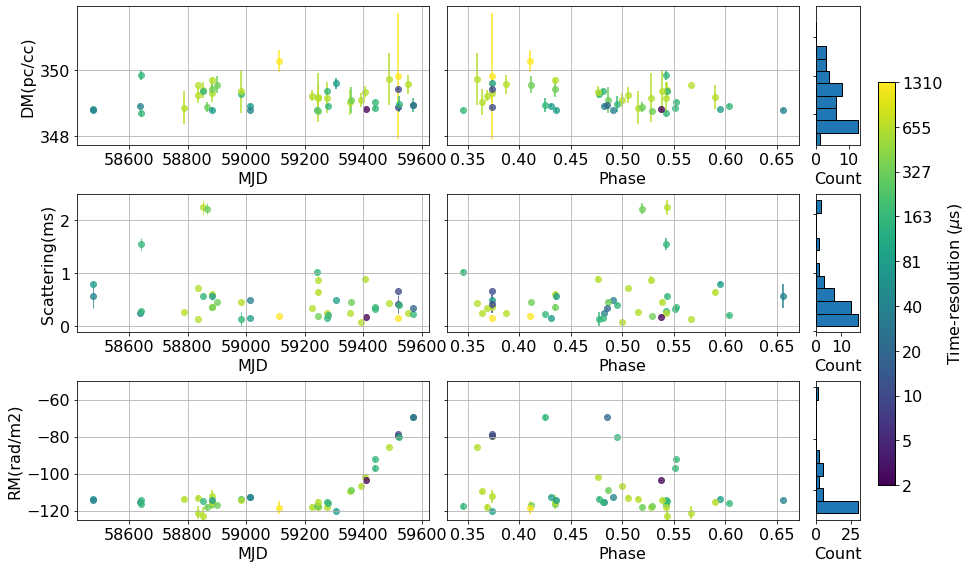

In [24]:
fig, ax = plt.subplots(3, 3, figsize = (12,8), gridspec_kw={'width_ratios': [2, 2, 0.25]})

tick_sizes = 16
font_sizes = 16


#### DM ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
dm = data['DM_final'].to_numpy().astype(float)

dm_test_result = adfuller(dm) ### Test to check whether time series is stationary. 
print("The Adfuller p value for DM", dm_test_result[1]) #### If p-value < 0.05 then stationary

dm_err = data['DM_err_final'].to_numpy().astype(float)
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, dm, dm_err, width_color):
    ax[0,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

# ax[1 ,0].errorbar(TOA_i3, dm_i3, yerr=dm_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[1 ,0].errorbar(TOA_i2, dm_i2, yerr=dm_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[0, 0].set_ylabel("DM(pc/cc)", fontsize = font_sizes)
ax[0, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[0, 0].grid()


for x, y, e, color in zip(phase, dm, dm_err, width_color):
    ax[0, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[1 ,1].errorbar(phase_i3, dm_i3, yerr=dm_err_i3, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[1 ,1].errorbar(phase_i2, dm_i2, yerr=dm_err_i2, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[1, 1].set_ylabel("DM(pc/cc)", fontsize = 14)
ax[0, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[0, 1].grid()

ax[0, 2].hist(dm, orientation='horizontal', edgecolor='k', range=(348.6,350.2))
ax[0, 2].set_xlabel("Count", fontsize=font_sizes)
ax[0, 2].set_ylim(348.6,350.4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[0, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[0, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[0, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()

##### Scattering ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
sc = data['Scattering(s)'].to_numpy().astype(float)

sc_test_result = adfuller(sc) ### Test to check whether time series is stationary. 
print("The Adfuller p value for scattering", sc_test_result[1]) #### If p-value < 0.05 then stationary

sc_err = data['Sc_err_sim(s)'].to_numpy().astype(float)

TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)

c_dsamps = np.zeros(len(d)).astype('str')

norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)

for x, y, e, color in zip(TOA, sc*1000, sc_err*1000, width_color): 
    ax[1 ,0].errorbar(x, y, yerr=e, lw=1, color=color, zorder=1, alpha=0.75, marker = 'o')

## Intensity Part ###
# ax[0 ,0].errorbar(TOA_i3, sc_i3*1000, yerr=sc_err_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')

# ax[0 ,0].errorbar(TOA_i2, sc_i2*1000, yerr=sc_err_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

ax[1, 0].set_ylabel("Scattering(ms)", fontsize = font_sizes)
ax[1, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[1, 0].grid()


for x, y, e, color in zip(phase, sc*1000, sc_err*1000, width_color):
    ax[1, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


# ax[0 ,1].errorbar(phase_i3, sc_i3*1000, yerr=sc_err_i3*1000, lw=1, color='r', zorder=1, alpha=1, marker = 'x',
#                  linestyle='')
# ax[0 ,1].errorbar(phase_i2, sc_i2*1000, yerr=sc_err_i2*1000, lw=1, color='k', zorder=1, alpha=1, marker = '^',
#                  linestyle='')

#ax[0, 1].set_ylabel("Scattering(ms)", fontsize = 14)
ax[1, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[1, 1].grid()

ax[1, 2].hist(sc*1000, orientation='horizontal', edgecolor='k')
ax[1, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')


ax[1, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[1, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[1, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()
#plt.savefig("Scattering_2.jpeg", dpi = 300, bbox_inches = 'tight')


#### RM ####

d = np.log2(data['Downsample'].to_numpy()).astype(int)
rm = data['RM_QU'].to_numpy().astype(float)
rm_err = data['RM_QU_err'].to_numpy().astype(float)
TOA = data['MJD'].to_numpy().astype(float)
phase = data['phase'].to_numpy().astype(float)
c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)


for x, y, e, color in zip(TOA, rm, rm_err, width_color):
    ax[2,0].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

ax[2, 0].set_ylabel("RM(rad/m2)", fontsize = font_sizes)
ax[2, 0].set_xlabel("MJD", fontsize = font_sizes)
ax[2, 0].set_ylim(-125, -50)
ax[2, 0].grid()


for x, y, e, color in zip(phase, rm, rm_err, width_color):
    ax[2, 1].errorbar(x, y, yerr=e, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


#ax[2, 1].set_ylabel("RM(rad/m2)", fontsize = 14)
ax[2, 1].set_xlabel("Phase", fontsize = font_sizes)
ax[2, 1].set_ylim(-125, -50)
ax[2, 1].grid()

ax[2, 2].hist(rm, orientation='horizontal', edgecolor='k')
ax[2, 2].set_xlabel("Count", fontsize=font_sizes)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

ax[2, 0].tick_params(axis='both', which='both', labelsize=tick_sizes)
ax[2, 1].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)
ax[2, 2].tick_params(axis='both', which='both', labelsize=tick_sizes, labelleft=False)

fig.tight_layout()

fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
cb = fig.colorbar(mapper, cax=cbar_ax)
ytick_lab = (np.logspace(0,9,base=2,num=10)*2.56).astype(int)
print(ytick_lab)
cbar_ax.set_yticklabels(ytick_lab)
cb.set_label(label=r'Time-resolution ($\mu$s)', size=font_sizes)
cbar_ax.tick_params(labelsize=tick_sizes)

plt.savefig("Final_plots/Scattering_DM_RM_properties.jpg", dpi = 300, bbox_inches = 'tight')
plt.subplots_adjust(wspace=0.07, hspace=0.35)
plt.show()

<ipython-input-19-ddb50941da56>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


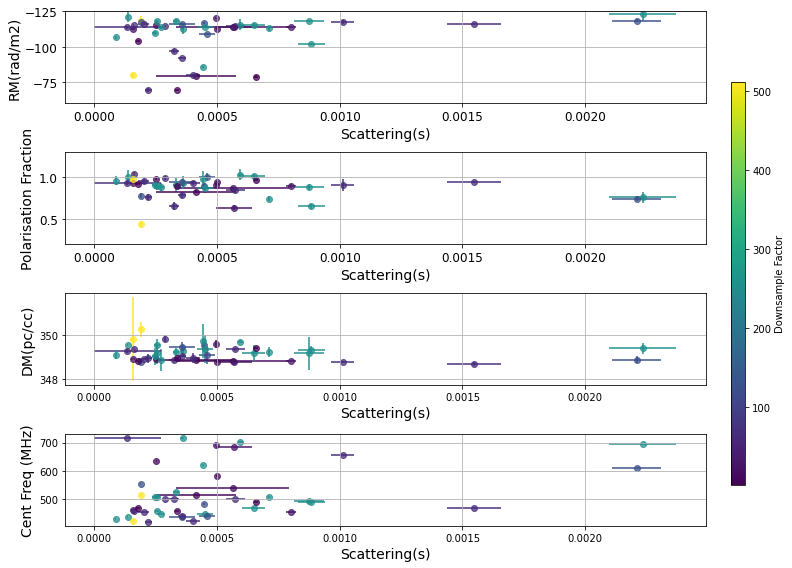

In [19]:
##### RM vs Scattering #####
#fig, ax = plt.subplots(2, 1, figsize = (20,17))
d = data['Downsample'].to_numpy().astype(int)

sc = data['Scattering(s)'].to_numpy().astype(float)
sc_err = data['Sc_err_sim(s)'].to_numpy().astype(float)

rm = data['RM_QU'].to_numpy().astype(float)
rm_err = data['RM_QU_err'].to_numpy().astype(float)

f_pol = data['F_POL'].to_numpy().astype(float)
f_pol_err = data['F_POL_err'].to_numpy().astype(float)

dm = data['DM_final'].to_numpy().astype(float)
dm_err = data['DM_err_final'].to_numpy().astype(float)

cf = data['Center_Freq'].to_numpy().astype(float)
cf_err = np.zeros(len(cf))

c_dsamps = np.zeros(len(d)).astype('str')


norm = mpl.colors.Normalize(vmin=np.min(d), vmax=np.max(d), clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
width_color = np.array([(mapper.to_rgba(v)) for v in d])
#print(width_color)

fig, ax = plt.subplots(4, 1, figsize = (10,8))

for x, y, xe, ye, color in zip(sc, rm, sc_err, rm_err,width_color):
    ax[0].errorbar(x, y, xerr=xe, yerr=ye, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

ax[0].set_ylim(-60,-125)
ax[0].set_ylabel("RM(rad/m2)", fontsize = 14)
ax[0].set_xlabel("Scattering(s)", fontsize = 14)
ax[0].grid()


for x, y, xe, ye, color in zip(sc, f_pol, sc_err, f_pol_err, width_color):
    ax[1].errorbar(x, y, xerr=xe, yerr=ye, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')


ax[1].set_ylim(0.2,1.3)
ax[1].set_ylabel("Polarisation Fraction", fontsize = 14)
ax[1].set_xlabel("Scattering(s)", fontsize = 14)
ax[1].grid()

for x, y, xe, ye, color in zip(sc, dm, sc_err, dm_err,width_color):
    ax[2].errorbar(x, y, xerr=xe, yerr=ye, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

ax[2].set_ylabel("DM(pc/cc)", fontsize = 14)
ax[2].set_xlabel("Scattering(s)", fontsize = 14)
ax[2].grid()

for x, y, xe, ye, color in zip(sc, cf, sc_err, cf_err,width_color):
    ax[3].errorbar(x, y, xerr=xe, yerr=ye, lw=2, color=color, zorder=1, alpha=0.75, marker = 'o')

ax[3].set_ylabel("Cent Freq (MHz)", fontsize = 14)
ax[3].set_xlabel("Scattering(s)", fontsize = 14)
ax[3].grid()

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.02, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax, label='Downsample Factor')

for i in range(2):
    ax[i].tick_params(axis='both', which='both', labelsize=12)

fig.tight_layout()
#plt.savefig("RM.jpeg", dpi = 300, bbox_inches = 'tight')
plt.show()

Structure function scattering


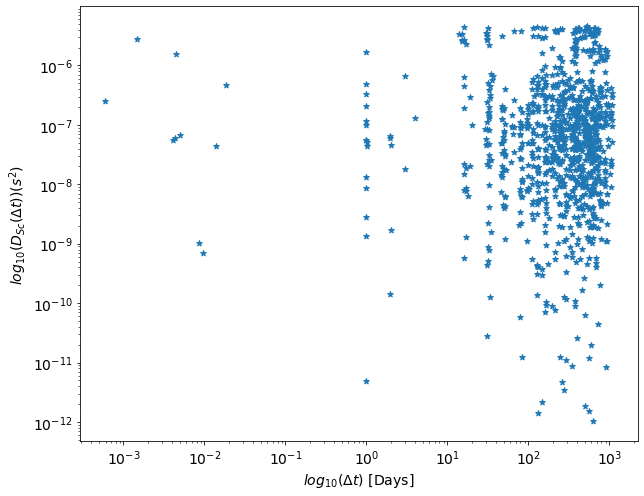

Structure function DM


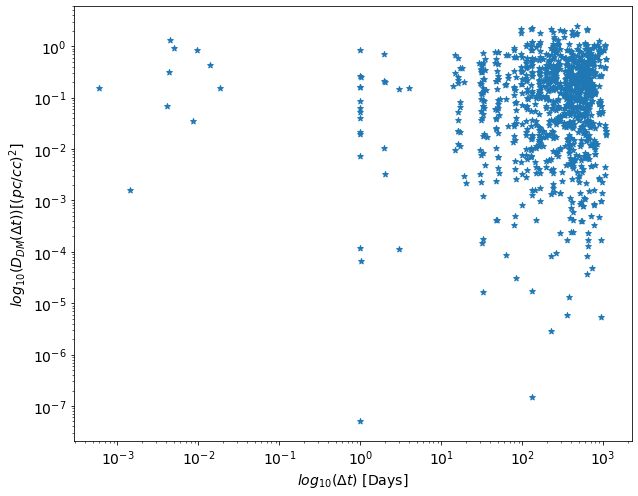

Structure function Width


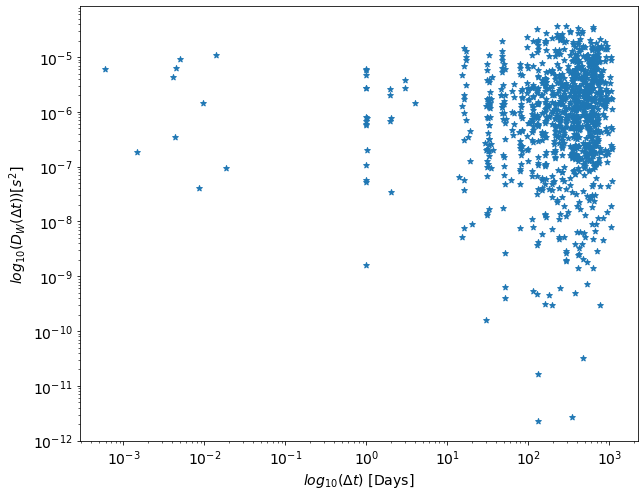

In [20]:
### Structure function analysis ###



def struct_func(TOA, prop, err):
    arr_t= TOA
    arr_d= prop
    arr_e= err
    
    n=len(arr_t)

    pair_num=(n*(n-1))/2
    dist=np.zeros(int(pair_num))
    diff=np.zeros(int(pair_num))
    error=np.zeros(int(pair_num))
    selected=np.arange(n)

    k = 0
    # Pick all elements one by one 
    for i in range(0, n): 

        # See if there is a pair of this picked element 
        for j in range(i+1, n) : 

            dist[k]=abs(arr_t[selected[i]]-arr_t[selected[j]])
            diff[k]=(arr_d[selected[i]]-arr_d[selected[j]])**2
            error[k]=np.sqrt((2*arr_e[selected][i]**2) + (2*arr_e[selected][j]**2))
            k+=1
            
    return dist, diff, error

#### Scattering ####

sc = data['Scattering(s)'].to_numpy().astype(float)
sc_err = data['Sc_err_sim(s)'].to_numpy().astype(float)
TOA = data['MJD'].to_numpy().astype(float)

dist_sc, diff_sc, error_sc = struct_func(TOA, sc, sc_err)

print("Structure function scattering")

# plt.xscale('log')
# plt.yscale('log')
# plt.errorbar(dist_sc, diff_sc, yerr=error_sc, linestyle='', marker='*')
# plt.show()

plt.figure(figsize=(10,8))

plt.xscale('log')
plt.yscale('log')
plt.scatter(dist_sc, diff_sc, marker='*')
plt.xlabel(r"$log_{10}(\Delta t)$ [Days]", fontsize=14)
plt.ylabel(r"$log_{10}(D_{Sc}(\Delta t))(s^{2})$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# ##### DM #####

dm = data['DM_final'].to_numpy().astype(float)
dm_err = data['DM_err_final'].to_numpy().astype(float)

print("Structure function DM")

dist_dm, diff_dm, error_dm = struct_func(TOA, dm, dm_err)

# plt.xscale('log')
# plt.yscale('log')
# plt.errorbar(dist_dm, diff_dm, yerr=error_dm, linestyle='', marker='*')
# plt.show()

plt.figure(figsize=(10,8))

plt.xscale('log')
plt.yscale('log')
plt.scatter(dist_dm, diff_dm, marker='*')
plt.xlabel(r"$log_{10}(\Delta t)$ [Days]", fontsize=14)
plt.ylabel(r"$log_{10}(D_{DM}(\Delta t))[(pc/cc)^{2}]$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


# ##### Width #######

w = w_sum
w_err = np.zeros(len(w))
for i in range(len(w)):
    q = d[i]*2.56e-6
    if w_err_sum[i] < q:
        w_err[i] = q
    else:
        w_err[i] = w_err_sum[i]

print("Structure function Width")

dist_w, diff_w, error_w = struct_func(TOA, w, w_err)

# plt.xscale('log')
# plt.yscale('log')
# plt.errorbar(dist_dm, diff_dm, yerr=error_dm, linestyle='', marker='*')
# plt.show()

plt.figure(figsize=(10,8))

plt.xscale('log')
plt.yscale('log')
plt.scatter(dist_w, diff_w, marker='*')
plt.xlabel(r"$log_{10}(\Delta t)$ [Days]", fontsize=14)
plt.ylabel(r"$log_{10}(D_{W}(\Delta t))[s^2]$", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()





In [21]:
#### Edit and make it table worthy #####
sc_tab = []
dm_tab = []
w_tab = []

sc_err_tab = []
dm_err_tab = []

#### The width ####

width = data['Widths(s)'].to_numpy()
width_err = data['Width_err(s)'].to_numpy()
w = np.zeros(len(width))
w_err = np.zeros(len(width))
w_ = []
w_err_ = []
down = data['Downsample'].to_numpy()
for i in range(len(w)):
    x = width[i][1:-1].split()
    y = width_err[i][1:-1].split()
    x = [float(x) for x in x]
    y = [float(y) for y in y]
    w_.append(x)
    w_err_.append(y)

for i in range(len(w_)):
    a = ''
    #print("\n",i)
    for j in range(len(w_[i])):
#         print("This burst has {} components".format(len(w_[i])))
        if w_err_[i][j] < (2.56e-6):
            w_err_[i][j] = down[i]*2.56e-6
        if (0 < w_[i][j] < 0.1) and (w_[i][j] > 2.56e-6) and (w_[i][j] > w_err_[i][j]) :
            #print("The width and error is", w_[i][j], w_err_[i][j])
            err = np.round(w_err_[i][j]*1e3,3)
            err = err*1e3
            err = str(int(err))
            if len(w_[i]) > 1:
                #a = a + str(+np.round(w_[i][j]*1e3,3))+'('+err+')'
                a = a + '{:.3f}'.format(round(w_[i][j]*1000, 3)) + '('+err+')'
            else:
                a = '{:.3f}'.format(round(w_[i][j]*1000, 3)) + '('+err+')'

        else:
            print("For burst {} the component {} is wrong".format(i+1, j+1))
            print("This width is wrong", w_[i][j], w_err_[i][j])
    w_tab.append(a)
    
print(w_tab)

##### The scattering #####

for i in range(len(sc_err)):
    x = (sc_err[i]*1e3).round(3)
    x = x*1e3
    x = str(int(x))

    sc_err_tab.append(x)
    
##### The DM #####
for i in range(len(dm_err)):
    if dm_err[i] < 1:
        x = (dm_err[i]).round(3)
        x = x*1e3
        x = str(int(x))
        dm_err_tab.append(x)
    else:
        dm_err_tab.append(str(dm_err[i].round(1)))
        
#### The bandwidth ####

freq_tab = []

for i in range(len(bw)):
    u = cf[i]+bw[i]/2
    l = cf[i]-bw[i]/2
    
    if u > 800:
        u = 800.0
    if l < 400:
        l = 400.0
    x = str(np.round(l,1))+'-'+str(np.round(u,1))
    freq_tab.append(x)
    



for i in range(len(sc)):
    s = '{:.3f}'.format(round(sc[i]*1000, 3))+'('+sc_err_tab[i]+')'
    sc_tab.append(s)
    d_t = str(dm[i].round(3))+'('+dm_err_tab[i]+')'
    d_t = '{:.3f}'.format(round(dm[i], 3))+'('+dm_err_tab[i]+')'
    dm_tab.append(d_t)
print(sc_tab)
print("\n")
print(dm_tab)

For burst 5 the component 2 is wrong
This width is wrong 0.000138754355 0.000175124921
For burst 5 the component 4 is wrong
This width is wrong 6.84351834e-07 3.54496784e-05
For burst 42 the component 2 is wrong
This width is wrong -0.20152836 2808712.62
['0.198(24)0.434(59)', '0.165(8)0.186(25)', '1.044(41)0.873(3)1.496(41)0.996(66)', '2.214(5)', '4.396(577)0.262(83)1.568(54)0.612(60)', '2.863(156)', '4.538(16)0.924(141)', '2.476(59)', '1.058(162)', '0.586(101)1.372(82)', '1.295(159)0.105(37)', '1.045(8)', '2.718(215)2.143(372)', '1.372(22)', '0.169(18)', '4.019(15)', '0.306(3)2.651(84)', '1.834(217)', '1.376(34)', '0.078(5)2.014(6)1.058(85)', '3.482(184)5.115(30)', '1.763(101)', '0.417(80)0.193(48)', '2.119(170)', '0.672(32)0.543(59)2.268(4)', '1.669(206)', '1.783(14)', '2.557(76)', '0.908(70)', '1.430(5)', '1.564(18)', '1.378(135)', '1.872(3)', '1.784(172)', '0.126(3)', '0.868(75)0.161(21)0.108(31)', '0.689(67)', '1.761(20)1.514(95)', '3.423(43)', '0.976(12)', '0.378(17)0.087(11)', 

In [261]:
### Make csv for table ###
data_table = data[['Event_id','MJD','phase','Downsample']]
b = []
for i in range(len(sc)):
    b.append('B'+str(i+1))
data_table['Burst'] = b
    
data_table["DM(pc/cc)"] = dm_tab
data_table["phase"] = data_table["phase"].round(3)
data_table["Scattering(ms)"] = sc_tab
data_table["Frequency Range(MHz)"] = freq_tab
data_table["MJD"] = data_table["MJD"].round(6)
data_table["Width(ms)"] = w_tab
#data_table["Width(ms)"] = (data_table["Widths(s)"]*1000).round(3)
data_table = data_table.reset_index(drop=True)
data_table=data_table[["Burst","Event_id","MJD","phase","Downsample","DM(pc/cc)","Scattering(ms)","Width(ms)","Frequency Range(MHz)"]]
print(data_table)

   Burst   Event_id           MJD  phase  Downsample     DM(pc/cc)  \
0     B1   23789294  58477.161851  0.595          32   348.812(20)   
1     B2   23891929  58478.155210  0.656          16   348.801(28)   
2     B3   40363753  58638.716433  0.482          16   348.919(32)   
3     B4   40750224  58639.705612  0.543          64  349.845(152)   
4     B5   40750656  58639.710081  0.543          64   348.690(83)   
5     B6   60073678  58786.320749  0.515         256  348.861(494)   
6     B7   65395717  58835.173236  0.505         256  349.243(235)   
7     B8   65511496  58836.171977  0.566         256   349.540(10)   
8     B9   67522832  58852.136284  0.543         256  349.390(234)   
9    B10   67522901  58852.137732  0.543          64   349.350(84)   
10   B11   69509443  58868.075857  0.519         128  348.883(146)   
11   B12   71665813  58882.046806  0.374         256  349.292(276)   
12   B13   71784400  58883.039950  0.435         128  349.438(264)   
13   B14   71784833 

<ipython-input-261-07ca3fdc06d7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_table['Burst'] = b
<ipython-input-261-07ca3fdc06d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_table["DM(pc/cc)"] = dm_tab
<ipython-input-261-07ca3fdc06d7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [262]:
data_table.to_csv('BB_data_R3_table.csv')

In [22]:
data.to_csv('BB_data_R3.csv')